In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
def compute_iou(pred, mask):
    pred = pred // 255 
    mask = mask // 255

    intersection = np.logical_and(pred, mask).sum()
    union = np.logical_or(pred, mask).sum()
    iou = intersection / union if union != 0 else 0
    return iou

def compute_dice(pred, mask):
    pred = pred // 255
    mask = mask // 255

    intersection = np.logical_and(pred, mask).sum()
    dice = (2 * intersection) / (pred.sum() + mask.sum()) if (pred.sum() + mask.sum()) != 0 else 0
    return dice

In [3]:
def segmentation(img, mask):
    
    # Read in the image
    image = cv.imread(img)

    # Change color to RGB (from BGR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Read the mask and convert it to binary
    mask = cv.imread(mask,cv.IMREAD_GRAYSCALE)
    _, mask = cv.threshold(mask, 127, 255, cv.THRESH_BINARY)

    # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
    pixel_vals = image.reshape((-1,3))

    # Convert to float type
    pixel_vals = np.float32(pixel_vals)

    # Morphological operations to improve segmentation
    kernel = np.ones((3, 3), np.uint8)

    # Define criteria = ( type, max_iter = 100 , epsilon = 0.85)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.85)

    # ======== KMEANS ==============
    # Perform k-means clustering with 2 clusters
    k = 2
    retval, labels, centers = cv.kmeans(pixel_vals, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    # Convert data into 8-bit values
    centers = np.uint8(centers)
    segmented_data_kmeans = centers[labels.flatten()]

    # Reshape data into the original image dimensions
    segmented_image_kmeans = segmented_data_kmeans.reshape((image.shape))

    # Convert to grayscale first (since we want black and white)
    segmented_gray_kmeans = cv.cvtColor(segmented_image_kmeans, cv.COLOR_RGB2GRAY)

    # Apply threshold to make it strictly black and white
    _, binary_kmeans = cv.threshold(segmented_gray_kmeans, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # do the opening & closing
    opened_kmeans = cv.morphologyEx(binary_kmeans, cv.MORPH_OPEN, kernel)
    morph_kmeans = cv.morphologyEx(opened_kmeans, cv.MORPH_CLOSE, kernel)

    #evaluation
    iou = compute_iou(binary_kmeans, mask)
    dice = compute_dice(binary_kmeans, mask)
    iou_morph = compute_iou(morph_kmeans, mask)
    dice_morph = compute_dice(morph_kmeans, mask)

    # ======== KMEANS++ ===============
    retval_pp, labels_pp, centers_pp = cv.kmeans(pixel_vals, k, None, criteria, 10, cv.KMEANS_PP_CENTERS)

    centers_pp = np.uint8(centers_pp)
    segmented_data_kmeans_pp = centers_pp[labels_pp.flatten()]

    segmented_image_kmeans_pp = segmented_data_kmeans_pp.reshape((image.shape))

    segmented_gray_kmeans_pp = cv.cvtColor(segmented_image_kmeans_pp, cv.COLOR_RGB2GRAY)

    _, binary_kmeans_pp = cv.threshold(segmented_gray_kmeans_pp, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    opened_kmeans_pp = cv.morphologyEx(binary_kmeans_pp, cv.MORPH_OPEN, kernel)
    morph_kmeans_pp = cv.morphologyEx(opened_kmeans_pp, cv.MORPH_CLOSE, kernel)

    iou_pp = compute_iou(binary_kmeans_pp, mask)
    dice_pp = compute_dice(binary_kmeans_pp, mask)
    iou_morph_pp = compute_iou(morph_kmeans_pp, mask)
    dice_morph_pp = compute_dice(morph_kmeans_pp, mask)

    # ===============================================

    print(f"IoU (k-means): {iou:.8f}")
    print(f"Dice (k-means): {dice:.8f}")

    print(f"\nIoU (k-means + morphological operations): {iou_morph:.8f}")
    print(f"Dice (k-means + morphological operations): {dice_morph:.8f}")

    print(f"\nIoU (k-means++): {iou_pp:.8f}")
    print(f"Dice (k-means++): {dice_pp:.8f}")

    print(f"\nIoU (k-means++ + morphological operations): {iou_morph_pp:.8f}")
    print(f"Dice (k-means++ + morphological operations): {dice_morph_pp:.8f}")

    # Display the original and segmented images
    plt.figure(figsize=(12, 8))
    plt.subplot(2,3,1), plt.imshow(image), plt.title('Original Image')
    plt.subplot(2,3,2), plt.imshow(binary_kmeans, cmap='gray'), plt.title('k-means')
    plt.subplot(2,3,3), plt.imshow(binary_kmeans_pp, cmap='gray'), plt.title('k-means++')
    plt.subplot(2,3,4), plt.imshow(mask, cmap='gray'), plt.title('Mask')
    plt.subplot(2,3,5), plt.imshow(morph_kmeans, cmap='gray'), plt.title('k-means + morphological')
    plt.subplot(2,3,6), plt.imshow(morph_kmeans_pp, cmap='gray'), plt.title('k-means++ + morphological')
    plt.show()

IoU (k-means): 0.54434086
Dice (k-means): 0.70494911

IoU (k-means + morphological operations): 0.54666493
Dice (k-means + morphological operations): 0.70689510

IoU (k-means++): 0.54653313
Dice (k-means++): 0.70678490

IoU (k-means++ + morphological operations): 0.54860926
Dice (k-means++ + morphological operations): 0.70851864


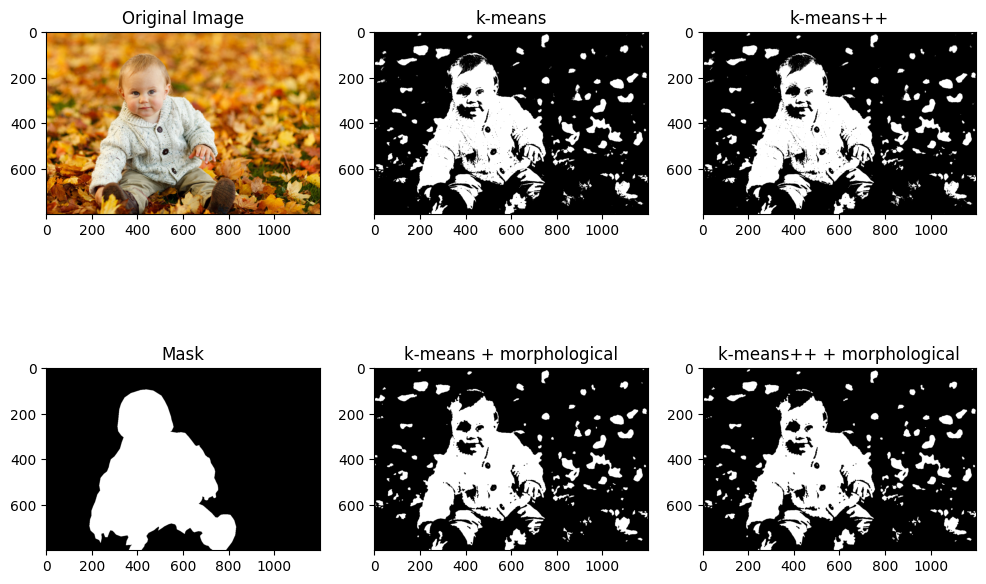

In [4]:
segmentation("baby.png", "baby_mask.png")

IoU (k-means): 0.14629001
Dice (k-means): 0.25524083

IoU (k-means + morphological operations): 0.14920735
Dice (k-means + morphological operations): 0.25967003

IoU (k-means++): 0.14630506
Dice (k-means++): 0.25526375

IoU (k-means++ + morphological operations): 0.14921521
Dice (k-means++ + morphological operations): 0.25968193


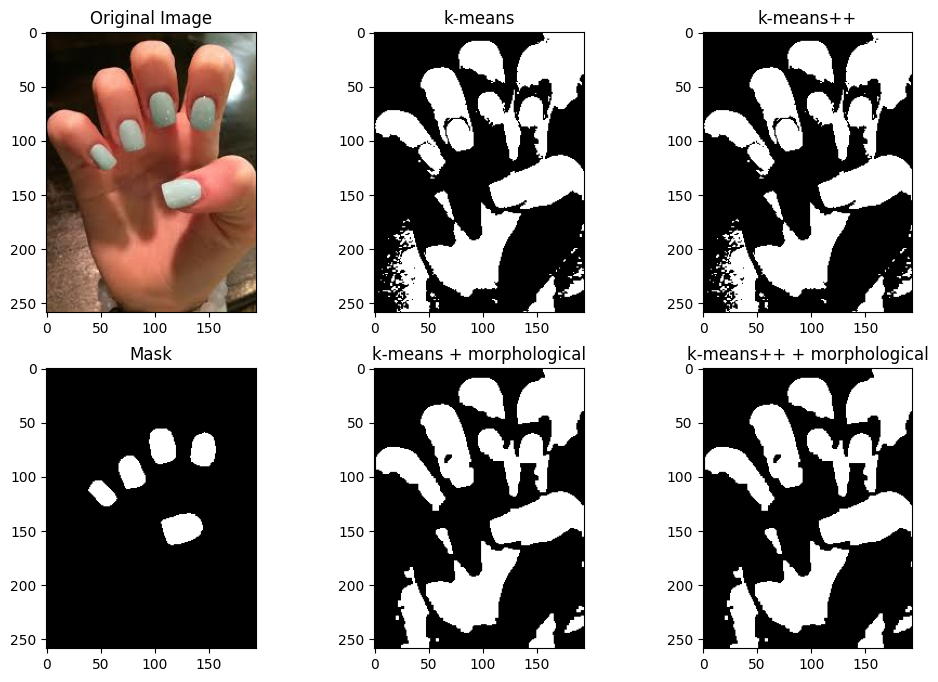

In [5]:
segmentation("nail.jpg", "nail_mask.jpg")

IoU (k-means): 0.44038122
Dice (k-means): 0.61147870

IoU (k-means + morphological operations): 0.44561923
Dice (k-means + morphological operations): 0.61650982

IoU (k-means++): 0.44178387
Dice (k-means++): 0.61282954

IoU (k-means++ + morphological operations): 0.44702539
Dice (k-means++ + morphological operations): 0.61785424


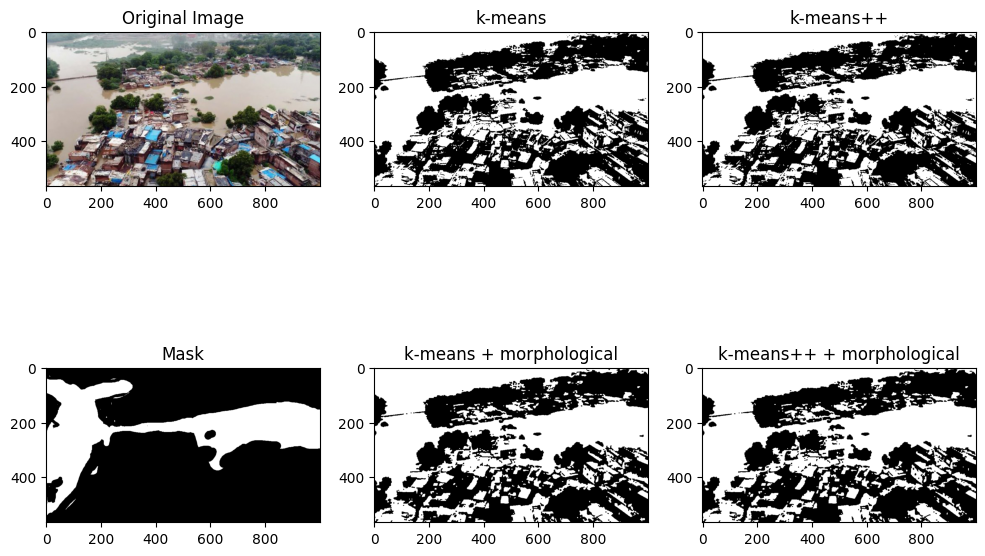

In [7]:
segmentation("flood.png", "flood_mask.png")